Epoch[1/25], G Loss: 1.8133, D Loss: -2.3626


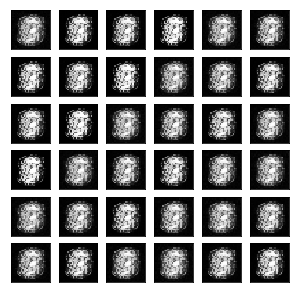

Epoch[2/25], G Loss: 1.7816, D Loss: -2.3848


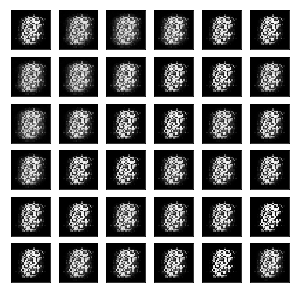

Epoch[3/25], G Loss: 1.8047, D Loss: -2.5679


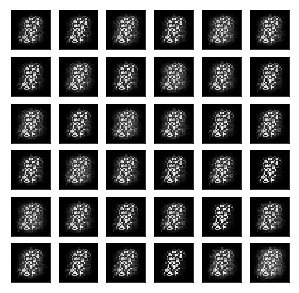

Epoch[4/25], G Loss: 1.6569, D Loss: -2.3820


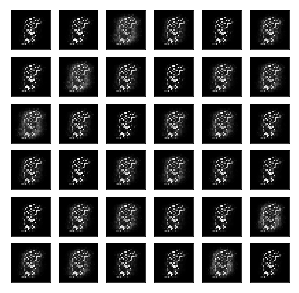

Epoch[5/25], G Loss: 1.5777, D Loss: -2.3074


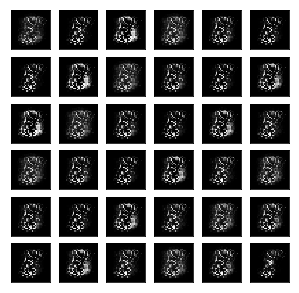

Epoch[6/25], G Loss: 1.6051, D Loss: -2.3210


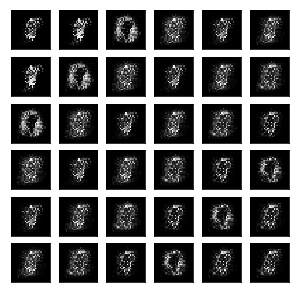

Epoch[7/25], G Loss: 1.6667, D Loss: -2.4055


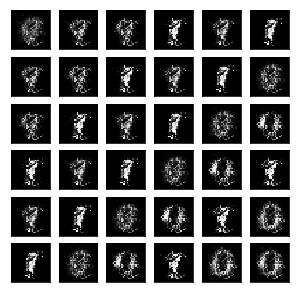

Epoch[8/25], G Loss: 1.7583, D Loss: -2.5421


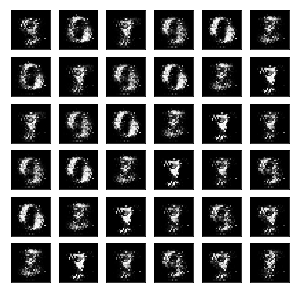

Epoch[9/25], G Loss: 1.6996, D Loss: -2.3789


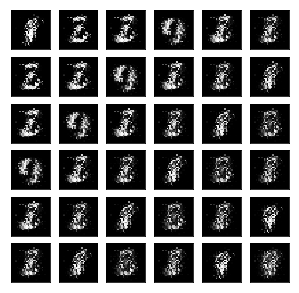

Epoch[10/25], G Loss: 1.6186, D Loss: -2.1656


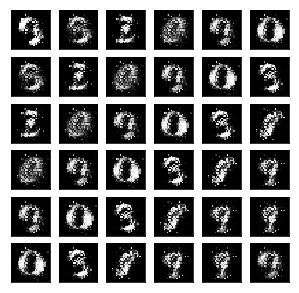

Epoch[11/25], G Loss: 1.7141, D Loss: -2.3889


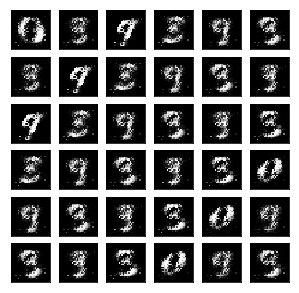

Epoch[12/25], G Loss: 1.7265, D Loss: -2.4199


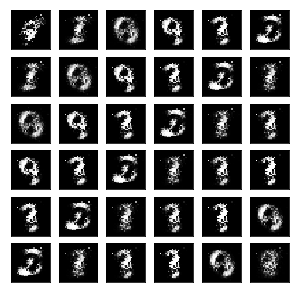

Epoch[13/25], G Loss: 1.6905, D Loss: -2.3995


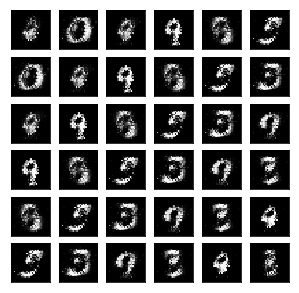

Epoch[14/25], G Loss: 1.6150, D Loss: -2.2406


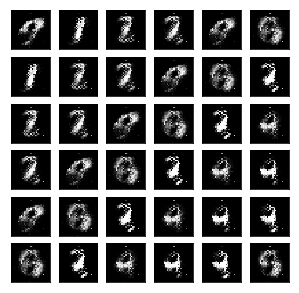

Epoch[15/25], G Loss: 1.7438, D Loss: -2.4693


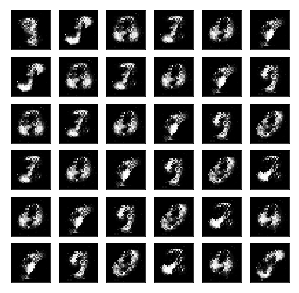

Epoch[16/25], G Loss: 1.7667, D Loss: -2.5198


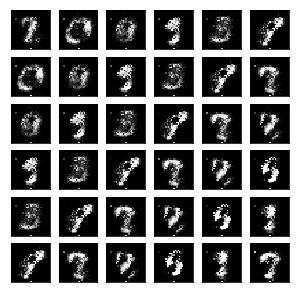

Epoch[17/25], G Loss: 1.7722, D Loss: -2.5356


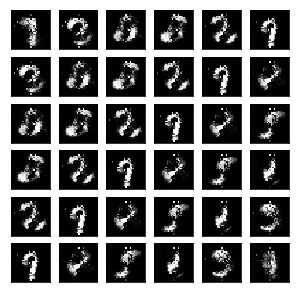

Epoch[18/25], G Loss: 1.7924, D Loss: -2.5730


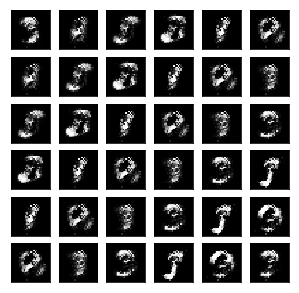

Epoch[19/25], G Loss: 1.8058, D Loss: -2.6128


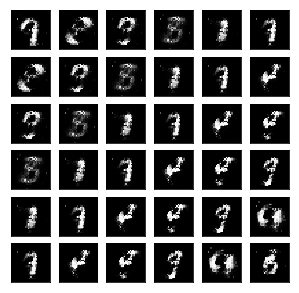

Epoch[20/25], G Loss: 1.7839, D Loss: -2.5732


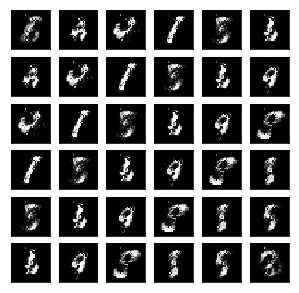

Epoch[21/25], G Loss: 1.7831, D Loss: -2.5569


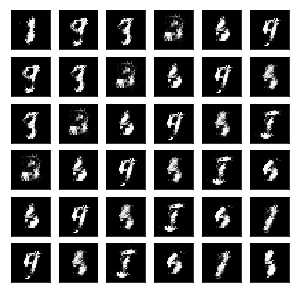

Epoch[22/25], G Loss: 1.7805, D Loss: -2.5400


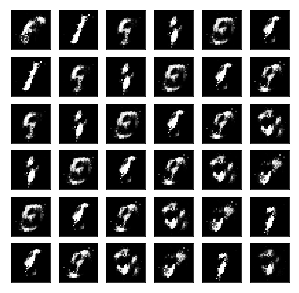

Epoch[23/25], G Loss: 1.7742, D Loss: -2.5396


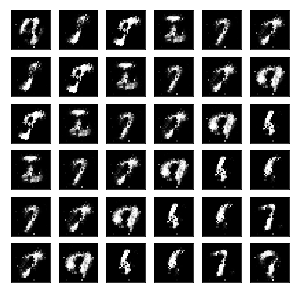

Epoch[24/25], G Loss: 1.8022, D Loss: -2.5813


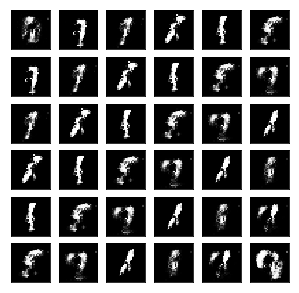

Epoch[25/25], G Loss: 1.8165, D Loss: -2.6144


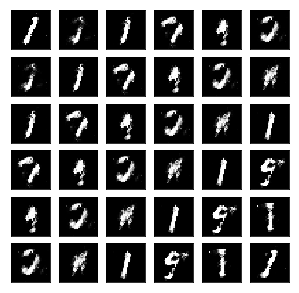

In [4]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.f_gan import *

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = fGAN(image_size=784,
             hidden_dim=256,
             z_dim=128)

# Init trainer
trainer = fGANTrainer(model=model,
                      train_iter=train_iter,
                      val_iter=val_iter,
                      test_iter=test_iter,
                      viz=True)
# Train
trainer.train(num_epochs=25,
              method='jensen_shannon',
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)